In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os

In [5]:
import dataset_utils
from glob import glob

In [6]:
DATA_DIR = "3_class_data"
NUM_POINTS = 100
NUM_CLASSES = 3
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_utils.parse_dataset(NUM_POINTS, DATA_DIR)

processing class: walking
processing class: jumping
processing class: speedwalking


In [7]:
print(train_points)

[[[ 7.031e-02  0.000e+00  1.003e-01  7.515e-01  1.460e+02]
  [ 1.702e-01  3.362e-01  6.064e-01  5.010e-01  3.220e+02]
  [ 2.494e-01  6.060e-01  6.147e-01  5.010e-01  3.220e+02]
  ...
  [ 5.508e-01  6.641e-01  4.958e-01  8.765e-01  3.040e+02]
  [ 1.000e+00  9.717e-01  7.764e-01  7.515e-01  2.720e+02]
  [ 6.616e-01  9.214e-01  5.000e-01  5.010e-01  3.240e+02]]

 [[ 2.000e-01  2.067e-01  0.000e+00  5.010e-01  2.470e+02]
  [ 9.991e-02  2.240e-01  8.711e-01 -3.757e-01  2.820e+02]
  [ 3.452e-01  9.497e-01  1.523e-01  7.515e-01  2.010e+02]
  ...
  [ 6.528e-01  7.407e-01  8.359e-01  8.765e-01  2.610e+02]
  [ 3.489e-01  1.256e-01  8.335e-01 -2.505e-01  2.360e+02]
  [ 6.147e-01  6.323e-01  3.655e-01  6.260e-01  2.910e+02]]

 [[ 1.895e-01  4.395e-01  3.643e-01 -5.010e-01  1.940e+02]
  [ 3.811e-01  3.364e-01  7.627e-01 -3.757e-01  3.180e+02]
  [ 3.591e-01  3.267e-01  8.774e-01 -3.757e-01  2.820e+02]
  ...
  [ 5.562e-01  5.049e-01  8.047e-01  7.515e-01  2.720e+02]
  [ 2.927e-01  8.462e-01  7.378e-0

In [8]:
print(test_points)

[[[ 4.050e-01  1.000e+00  0.000e+00 -2.505e-01  3.000e+02]
  [ 1.000e+00  1.111e-01  1.000e+00 -2.505e-01  3.170e+02]
  [ 2.502e-01  3.611e-01  5.557e-01 -2.505e-01  3.180e+02]
  ...
  [ 4.050e-01  1.000e+00  0.000e+00 -2.505e-01  3.000e+02]
  [ 1.000e+00  1.000e+00  0.000e+00 -2.505e-01  3.000e+02]
  [ 1.672e-01  0.000e+00  9.971e-01 -2.505e-01  3.240e+02]]

 [[ 1.672e-01  0.000e+00  9.971e-01 -2.505e-01  3.240e+02]
  [ 9.595e-02  4.614e-01  7.100e-01  6.260e-01  3.080e+02]
  [ 6.665e-01  3.220e-01  8.730e-01  5.010e-01  3.070e+02]
  ...
  [ 1.000e+00  9.902e-01  4.951e-01  5.010e-01  3.510e+02]
  [ 7.866e-01  5.547e-01  8.960e-01  5.010e-01  3.340e+02]
  [ 0.000e+00  7.920e-01  2.085e-01  6.260e-01  3.170e+02]]

 [[ 1.672e-01  0.000e+00  9.971e-01 -2.505e-01  3.240e+02]
  [ 9.062e-01  9.900e-02  1.000e+00  5.010e-01  3.160e+02]
  [ 9.473e-01  1.389e-01  3.762e-01 -1.252e-01  1.990e+02]
  ...
  [ 4.207e-01  3.413e-01  8.438e-01 -2.505e-01  3.370e+02]
  [ 1.412e-01  2.054e-01  5.679e-0

In [9]:
# train_points = train_points[:, :, :3]
# test_points = test_points[:, :, :3]
print(CLASS_MAP)

{0: 'walking', 1: 'jumping', 2: 'speedwalking'}


In [10]:
print(train_points)

[[[ 7.031e-02  0.000e+00  1.003e-01  7.515e-01  1.460e+02]
  [ 1.702e-01  3.362e-01  6.064e-01  5.010e-01  3.220e+02]
  [ 2.494e-01  6.060e-01  6.147e-01  5.010e-01  3.220e+02]
  ...
  [ 5.508e-01  6.641e-01  4.958e-01  8.765e-01  3.040e+02]
  [ 1.000e+00  9.717e-01  7.764e-01  7.515e-01  2.720e+02]
  [ 6.616e-01  9.214e-01  5.000e-01  5.010e-01  3.240e+02]]

 [[ 2.000e-01  2.067e-01  0.000e+00  5.010e-01  2.470e+02]
  [ 9.991e-02  2.240e-01  8.711e-01 -3.757e-01  2.820e+02]
  [ 3.452e-01  9.497e-01  1.523e-01  7.515e-01  2.010e+02]
  ...
  [ 6.528e-01  7.407e-01  8.359e-01  8.765e-01  2.610e+02]
  [ 3.489e-01  1.256e-01  8.335e-01 -2.505e-01  2.360e+02]
  [ 6.147e-01  6.323e-01  3.655e-01  6.260e-01  2.910e+02]]

 [[ 1.895e-01  4.395e-01  3.643e-01 -5.010e-01  1.940e+02]
  [ 3.811e-01  3.364e-01  7.627e-01 -3.757e-01  3.180e+02]
  [ 3.591e-01  3.267e-01  8.774e-01 -3.757e-01  2.820e+02]
  ...
  [ 5.562e-01  5.049e-01  8.047e-01  7.515e-01  2.720e+02]
  [ 2.927e-01  8.462e-01  7.378e-0

In [11]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [12]:
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [13]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn

In [14]:
inputs = keras.Input(shape=(NUM_POINTS, 5))

x = tnet(inputs, 5)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 64)   │      2,112 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 100, 512)  │     33,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 100, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_2[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 25)        │      3,225 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 5)      │          0 │ dense_2[0][0]   

 Total params: 750,268 (2.86 MB)

 Trainable params: 744,188 (2.84 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [15]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=30, validation_data=validation_dataset)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 56.6779 - sparse_categorical_accuracy: 0.3857 - val_loss: 38.3051 - val_sparse_categorical_accuracy: 0.3750
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 37.8825 - sparse_categorical_accuracy: 0.4204 - val_loss: 38.0160 - val_sparse_categorical_accuracy: 0.3984
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 37.6913 - sparse_categorical_accuracy: 0.3999 - val_loss: 41.4214 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 37.5093 - sparse_categorical_accuracy: 0.4669 - val_loss: 37.7750 - val_sparse_categorical_accuracy: 0.4922
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 37.3933 - sparse_categorical_accuracy: 0.4754 - val_loss: 38.4356 - val_sparse_categorical_accuracy: 0.4062
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 37.4019 - sparse_categorical_accuracy: 0.3948 - val_loss: 37.7047 - val_sparse_categorical_accuracy: 0.382

In [16]:
from matplotlib import pyplot as plt

2024-08-15 21:04:20.472730: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
[[[ 2.7637e-01  5.0732e-01  9.8486e-01 -3.7573e-01  3.0700e+02]
  [ 1.0000e+00  2.3840e-01  5.9766e-01 -6.2598e-01  2.7700e+02]
  [ 8.4619e-01  7.5342e-01  2.3608e-01 -2.5049e-01  2.2900e+02]
  ...
  [ 4.4116e-01  6.7676e-01  2.1973e-01 -7.5146e-01  1.9800e+02]
  [ 1.6187e-01  7.5830e-01  7.4121e-01 -3.7573e-01  3.4400e+02]
  [ 3.7769e-01  3.9355e-01  5.6152e-01 -5.0098e-01  3.1300e+02]]

 [[ 3.7305e-01  4.2920e-01  8.6182e-01 -3.7573e-01  3.1500e+02]
  [ 2.2156e-01  2.6733e-01  0.0000e+00  5.0098e-01  2.8700e+02]
  [ 7.8174e-01  6.7236e-01  1.9226e-01 -3.7573e-01  3.0500e+02]
  ...
  [ 9.1553e-01  6.2305e-01  8.8477e-01 -2.5049e-01  2.1800e+02]
  [ 1.0000e+00  4.3848e-01  8.0957e-01  3.7573e-01  3.2200e+02]
  [ 3.3643e-01  6.7969e-01  4.0259e-01  6.2598e-01  2.8000e+02]]

 [[ 5.2832e-01  6.0449e-01  6.8066e-01 -8.7646e-01  3.8000e+02]
  [ 1.0000e+00  6.2061e-01  1.0449e-01 -7.5146e-01  3.0100e+02]
  [ 5.0439e-01  3.4155e-01  8.0322e-01 -8.7646e-0

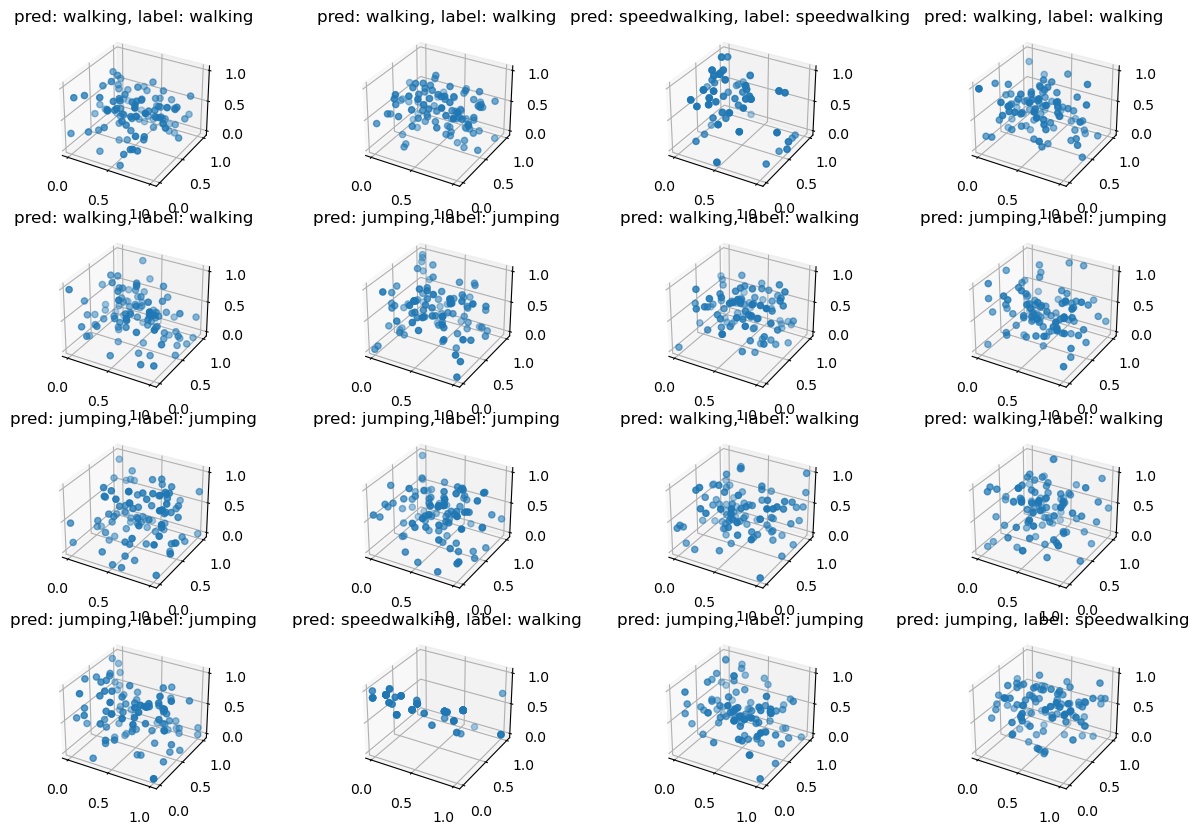

In [17]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [18]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [19]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 69.75%


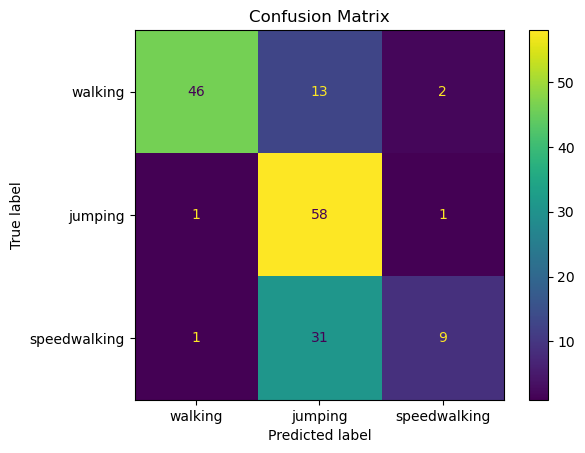

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plotting the confusion matrix
class_names = ['walking', 'jumping', 'speedwalking']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [18]:
# model.save('pointnet_2_class_data_5_dims.h5', save_format='h5')
# # model.get_config()

NotImplementedError: <PointNET.OrthogonalRegularizer object at 0x3108f52d0> does not implement get_config()